In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import torch
import seaborn as sns
import matplotlib.pyplot as plt
from experiments.run_experiment_realdata import run_pureGam
from torch_utils.dataset_util import PureGamDataset, PureGamDataset_smoothingInTraining
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
# todo: airfoil
seed = 1234
base_dir = "./"
dataset_name = "airfoil"
# dataset_name = "flat_dirichlet_generate"
model_output_dir = "../model_save/realdata/" + dataset_name + "/"
base_results_folder = results_folder = 'results_' + str(seed) + '/' + dataset_name

# Load Data from dataset
df = pd.read_csv(base_dir + "realdata/" + dataset_name + ".csv")
print("load data from ::", base_dir + "realdata/" + dataset_name + ".csv")

# "HoursPerWeek","TotalHours", carry ?"Age","APM"

X_num = df.loc[:, ["in1", "in2", "in3", "in4", "in5"]].values
X_cate = df.loc[:, []].values
# "L3","L4","L5"
y = df.loc[:, ["out"]].values
sy = MinMaxScaler((0, 1))
y = sy.fit_transform(y)
# run_pureGam_gami_kfold(X_num, X_cate, y, base_results_folder, seed=seed)


load data from :: ./realdata/airfoil.csv


In [3]:
X_num_train, X_num_test, X_cate_train, X_cate_test, y_train, y_test = train_test_split(X_num, X_cate, y, test_size=0.1, random_state=seed)
results_folder = "results/" + dataset_name
pureGam = run_pureGam(X_num_train, X_cate_train, y_train, X_num_test, X_cate_test, y_test,
                        results_folder=results_folder + '/' + 'pureGam', isPureScore=True, seed=seed, model_output_dir='model_save/realdata/airfoil/')

&&&& Device USED :: cuda:0
Full Interaction [[0, 1], [0, 2], [0, 3], [0, 4], [1, 2], [1, 3], [1, 4], [2, 3], [2, 4], [3, 4]]
Full Interaction []
{*} Model Size 10286
Param:: tensor([[5.0000e+02, 6.7000e+00, 1.0160e-01, 3.9600e+01, 5.7808e-03],
        [8.0000e+03, 4.8000e+00, 2.5400e-02, 3.1700e+01, 9.3079e-04],
        [8.0000e+03, 1.5000e+00, 3.0480e-01, 7.1300e+01, 3.3673e-03],
        [3.1500e+03, 1.7400e+01, 2.5400e-02, 3.1700e+01, 1.7663e-02],
        [6.3000e+03, 1.0000e-12, 5.0800e-02, 3.9600e+01, 7.9182e-04],
        [1.0000e+03, 1.0000e-12, 1.5240e-01, 3.1700e+01, 2.0941e-03],
        [1.6000e+03, 1.0000e-12, 5.0800e-02, 3.9600e+01, 7.9182e-04],
        [1.6000e+03, 1.0000e-12, 5.0800e-02, 7.1300e+01, 7.4048e-04],
        [8.0000e+03, 1.0000e-12, 1.0160e-01, 3.1700e+01, 1.5009e-03],
        [5.0000e+03, 8.9000e+00, 1.0160e-01, 7.1300e+01, 1.0309e-02]],
       device='cuda:0', dtype=torch.float64, grad_fn=<SliceBackward0>) tensor([[1.2500e+03, 7.3000e+00, 2.2860e-01, 7.1300e+0

/gpfs/ysm/home/xs272/reliableAI/XAI/pureGAM/metrics/metrics_torch.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  denom = th.square(th.tensor(INT)).mean().item()
/gpfs/ysm/home/xs272/reliableAI/XAI/pureGAM/metrics/metrics_torch.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  denom = th.square(th.tensor(int_pred[i])).mean().item()


compute pureness score : 1.018880844116211
                     train      test
r2                0.879713  0.816475
mse               0.004054  0.006046
time            407.112073  0.029769
log_pure_score    0.000000 -1.465146


In [4]:
batch_scale = 4
N_param_scale = 0.5# todo: 0.5
kwargs = {}
train_loader = torch.utils.data.DataLoader(PureGamDataset_smoothingInTraining(
    X_cate, torch.tensor(X_num).to(device), torch.tensor(y).to(device)),
    batch_size=int(batch_scale * 128), shuffle=False, **kwargs)

all_contri_univ = []
all_contri_biv = []
for _, batch_N_X, _ in train_loader:
    with torch.no_grad():
        y_hat_S, contri_mat_univ, contri_mat_biv, _, _, _ = pureGam.predict_batch_numerical(batch_N_X)
        all_contri_univ.append(contri_mat_univ.cpu().numpy().T)
        all_contri_biv.append(contri_mat_biv.cpu().numpy().T)

contri_univ = np.concatenate(all_contri_univ)
contri_biv = np.concatenate(all_contri_biv)
contri = np.c_[contri_univ, contri_biv]

<AxesSubplot:>

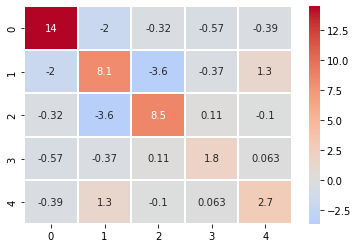

In [5]:
sns.heatmap(contri_univ.T @ contri_univ, mask=None, annot=True, center=0., linewidths=0.1, cmap="coolwarm")

<AxesSubplot:>

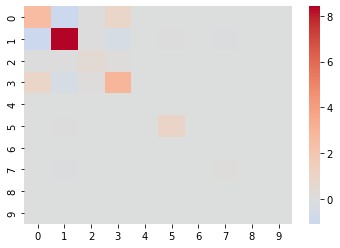

In [6]:
sns.heatmap(contri_biv.T @ contri_biv, mask=None, annot=False, center=0., linewidths=0., cmap="coolwarm")

/tmp/tmp.KHh4vP4VIF/ipykernel_8248/756916684.py:8: UserWarning: The following kwargs were not used by contour: 'center'
  contour = plt.tricontourf(expl_x1,expl_x2,expl_y, 100, center=0., cmap="coolwarm")


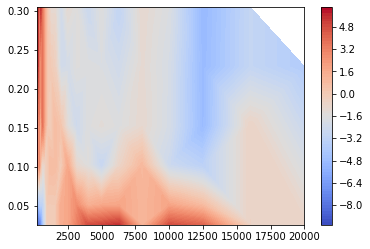

In [7]:
biv_cov_mat = contri_biv.T @ contri_biv
ind = biv_cov_mat.sum(axis=0).argsort()[-1]
[ind1, ind2] = pureGam.pairwise_idxes_num[ind]
expl_x1 = X_num[:, ind1]
expl_x2 = X_num[:, ind2]
expl_y = contri_biv[:, ind] / sy.scale_
fig = plt.figure()
contour = plt.tricontourf(expl_x1,expl_x2,expl_y, 100, center=0., cmap="coolwarm")
plt.colorbar()
plt.show()